# Proximal Policy Optimization

The goals behind proximal polixy optimization was to
- Limit the updates to ensure stable learning
- Off Policy to increase sample efficiency
- Simple to implement

Advantage Actor Critic Loss:
$
\begin{align}
L_{t}^{PG}(\theta) = E_{\pi}[log(\pi_{\theta}(a_{t}, s_{t}) A(s_{t}, a_{t}) ]
\end{align}
$

To limit the updates we first define a ratio between the new policy and old policy
$
\begin{align}
r_{t}(\theta) = \pi_{\theta} (a_{t} | s_{t}) / \pi_{\theta old} (a_{t} | s_{t})
\end{align}
$

We then replace it in the Policy Gradient Loss

$
\begin{align}
L_{t}^{CPI}(\theta) = E_{\pi}[\frac{\pi_{\theta} (a_{t} | s_{t})}{\pi_{\theta old} (a_{t} | s_{t})} A(s_{t}, a_{t}) ]
\end{align}
$



We then clip it using the following objective function

$
\begin{align}
L_{t}^{CLIP} = E_{t}[min(r_{t}(\theta) A_{t}, clip(r_{t}(\theta), 1-\epsilon, 1+\epsilon)  A_{t})]
\end{align}
$


Instead of having to throw away all samples after one update, PPO Also makes use of Importance Sampling by estimating the new policy using the expectation of the old policy.

It can thus be used as an off policy algorithm.

$
\begin{align}
E_{x-p} [f(x)] = \int f(x) p(x) dx
\end{align}
$
$
\begin{align}
               = \int f(x) \frac{p(x)}{q(x)} q(x) dx
\end{align}
$     
$
\begin{align}
               = E_{x-q} [f(x) \frac{p(x)}{q(x)}]
\end{align}
$



In [1]:
%matplotlib inline
import gym
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
from collections import deque
import matplotlib
from IPython.display import clear_output
import time

In [2]:
GAMMA = .95
env = gym.make('CartPole-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
EPSILON = .2
STEPS_PER_EPOCH = 4000
EPOCHS = 50
TRAIN_K_MINIBATCH = 80

In [3]:
print("State Shape", state_size)
print("Action Shape", action_size)

value_hist = []
pi_hist = []


State Shape 4
Action Shape 2


In [4]:
class PPO:
    def __init__(self, sess, state_size, action_size):
        self.sess = sess
        
        # Actor Critic Forward
        self.inputs = tf.placeholder(tf.float64, [None, state_size], name="inputs")
        self.returns = tf.placeholder(tf.float64, [None, 1], name="returns")
        self.advantages = tf.placeholder(tf.float64, [None, 1], name="advantages")
        self.actions = tf.placeholder(tf.int64, [None, 1], name="actions")
        self.logp_old = tf.placeholder(tf.float64, [None, 1], name="logp_old")
        
            
        self.actor_fc1 = tf.layers.dense(inputs = self.inputs,
                                  units = 64,
                                  activation = tf.nn.relu,
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        self.logits = tf.layers.dense(inputs = self.actor_fc1,
                                  units = action_size,
                                  activation = None,
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        
        self.critic_fc1 = tf.layers.dense(inputs = self.inputs,
                                  units = 64,
                                  activation = tf.nn.relu,
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        self.value = tf.layers.dense(inputs = self.critic_fc1,
                                  units = 1,
                                  activation = None,
                                  kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        
        self.logp_all = tf.nn.log_softmax(self.logits)
        
        # Sample actoin from probability distribution.
        self.pi = tf.squeeze(tf.multinomial(self.logits, 1), axis=1)
        self.logp_pi = tf.reduce_sum(tf.cast(tf.one_hot(self.pi, depth=action_size), dtype=tf.float64) * self.logp_all, axis=1)
        
        self.temp = tf.cast(tf.one_hot(self.actions, depth=action_size), dtype=tf.float64)
        
        self.temp = tf.reshape(self.temp, [-1, action_size])
        self.logp = tf.reduce_sum(tf.multiply(self.temp, self.logp_all), axis=1)
        
        self.logp = tf.reshape(self.logp, [-1, 1])
        
        # pi (at | st) / pi_old (at | st)
        # Do Exp of Log for numerical stability
        self.r_t = tf.exp(self.logp - self.logp_old)  
        
        # Clip the Objective function
        self.score = tf.minimum(tf.multiply(self.r_t, self.advantages), tf.multiply(tf.clip_by_value(self.r_t, 1 - EPSILON, 1 + EPSILON), self.advantages))
        
        self.pi_loss = - tf.reduce_mean(self.score)
        self.v_loss = tf.reduce_mean((self.returns - self.value) ** 2)
        
        self.pi_opt = tf.train.AdamOptimizer(1e-4).minimize(self.pi_loss)
        self.v_opt = tf.train.AdamOptimizer(1e-3).minimize(self.v_loss)

In [5]:
# Buffer to store details for training. Similar to Spinning Up AI.

class Buffer:
    def __init__(self, buffer_size, state_size, action_size):
        self.states = np.zeros([buffer_size, state_size], dtype=np.float64)
        self.actions = np.zeros([buffer_size, 1], dtype=np.int16)
        self.rewards = np.zeros([buffer_size, 1], dtype=np.float64)
        self.returns = np.zeros([buffer_size, 1], dtype=np.float64)
        self.logpis = np.zeros([buffer_size, 1], dtype=np.float64)
        self.vals = np.zeros([buffer_size, 1], dtype=np.float64)
        self.advantages = np.zeros([buffer_size, 1], dtype=np.float64)
        
        # Pointer maintains the currently added record.
        self.ptr = 0
        
        # Start Path maintains the last episode start Path
        self.start_path = 0
        
    def store(self, state, action, reward, logpi, val):
        self.states[self.ptr] = state
        self.actions[self.ptr] = action
        self.rewards[self.ptr] = reward
        self.logpis[self.ptr] = logpi
        self.vals[self.ptr] = val
        self.ptr += 1
    
    # While episode is finished calculate the advantages and reward to go.
    def finish(self, last_val=0):
        for t in reversed(range(self.start_path, self.ptr)):
            last_val = self.rewards[t] + GAMMA * last_val
            self.advantages[t] = last_val - self.vals[t]
            self.returns[t] = last_val
        self.start_path = self.ptr
        
    def get(self):
        # Reset the pointer and start path
        self.ptr, self.start_path = 0, 0
        mean = np.mean(self.advantages)
        std = np.std(self.advantages)
        self.advantages  = (self.advantages - mean) / std
        return self.states, self.actions, self.rewards, self.returns, self.logpis, self.vals, self.advantages
        

In [6]:
def update():
    states, actions, rewards, returns, logpis, vals, advantages = buffer.get()
    
    pi_loss_iteration = []
    
    # Train Loss and Pi for K iterations.
    for i in range(TRAIN_K_MINIBATCH):
        logp_old, temp, logp_all, logp, r_t, pi_loss, pi_opt =  sess.run([model.logp_old, model.temp, model.logp_all, model.logp, model.r_t, model.pi_loss, model.pi_opt], feed_dict = {
            model.inputs: states,
            model.returns: returns,
            model.advantages: advantages,
            model.actions: actions,
            model.logp_old: logpis
        })
        
    
    for i in range(TRAIN_K_MINIBATCH):
        v_loss, v_opt = sess.run([model.v_loss, model.v_opt], feed_dict={
            model.inputs: states,
            model.returns: returns
        })
        
    value_hist.append(v_loss)
    pi_hist.append(pi_loss)

In [7]:
max_reward = 0
finished_games = 0
total_reward = 0
state = env.reset()

sess = tf.Session()
scores = []
model = PPO(sess, state_size, action_size)
buffer = Buffer(STEPS_PER_EPOCH, state_size, action_size)
sess.run(tf.global_variables_initializer())
for epoch in range(EPOCHS):
    for t in range(STEPS_PER_EPOCH):
        pi, v, logp_pi = sess.run([model.pi, model.value, model.logp_pi], feed_dict={
            model.inputs: np.reshape(state, [-1, state_size])
        })
        new_state, reward, done, _ = env.step(pi[0])
        total_reward += reward
        buffer.store(state, pi[0], reward, logp_pi[0], v[0])

        if done or (t == STEPS_PER_EPOCH - 1):
            if not done:
                # Bootstrap last val
                last_val = sess.run(model.value, feed_dict={
                    model.inputs: np.reshape(new_state, [-1, state_size])
                })
            else:
                if total_reward > max_reward:
                    max_reward = total_reward
                finished_games += 1
                if finished_games % 100 == 0:
                    scores.append(total_reward)
                total_reward = 0
                last_val = reward
                state = env.reset()
                new_state = state
                done = False
            buffer.finish(last_val)
        state = new_state
    update()
    print("Epoch: ", epoch, "Max reward: ", max_reward)

Epoch:  0 Max reward:  67.0
Epoch:  1 Max reward:  107.0
Epoch:  2 Max reward:  107.0
Epoch:  3 Max reward:  107.0
Epoch:  4 Max reward:  135.0
Epoch:  5 Max reward:  135.0
Epoch:  6 Max reward:  135.0
Epoch:  7 Max reward:  135.0
Epoch:  8 Max reward:  158.0
Epoch:  9 Max reward:  158.0
Epoch:  10 Max reward:  158.0
Epoch:  11 Max reward:  200.0
Epoch:  12 Max reward:  200.0
Epoch:  13 Max reward:  200.0
Epoch:  14 Max reward:  200.0
Epoch:  15 Max reward:  200.0
Epoch:  16 Max reward:  200.0
Epoch:  17 Max reward:  200.0
Epoch:  18 Max reward:  200.0
Epoch:  19 Max reward:  200.0
Epoch:  20 Max reward:  200.0
Epoch:  21 Max reward:  200.0
Epoch:  22 Max reward:  200.0
Epoch:  23 Max reward:  200.0
Epoch:  24 Max reward:  200.0
Epoch:  25 Max reward:  200.0
Epoch:  26 Max reward:  200.0
Epoch:  27 Max reward:  200.0
Epoch:  28 Max reward:  200.0
Epoch:  29 Max reward:  200.0
Epoch:  30 Max reward:  200.0
Epoch:  31 Max reward:  200.0
Epoch:  32 Max reward:  200.0
Epoch:  33 Max reward

In [8]:
episodes = 100

ep_rew = []
for _ in range(episodes):
    total_reward = 0
    state = env.reset()
    done = False
    while not done:
        pi, value = sess.run([model.pi, model.value], feed_dict = {
            model.inputs : state.reshape([-1, state_size])
        })
        state, reward, done, _ = env.step(pi[0])
        total_reward += reward
    ep_rew.append(total_reward)
    
ep_rew = np.array(ep_rew)

print(f"Results after {episodes} episodes:")
print(f"Average Reward per episode: {ep_rew.mean()}")

Results after 100 episodes:
Average Reward per episode: 196.4


In [9]:
sess.close()

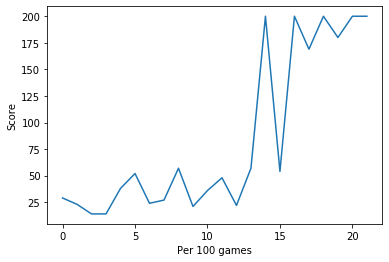

In [11]:
scores = np.array(scores)

plt.plot(scores)
plt.xlabel('Per 100 games')
plt.ylabel('Score')
plt.show()
